# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

df = pd.read_csv('drive/MyDrive/Machine Learning Course/datasources/tweet_sentiment_train.csv.zip')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [4]:
df.dropna(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [6]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


In [7]:
df['sentiment'].value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


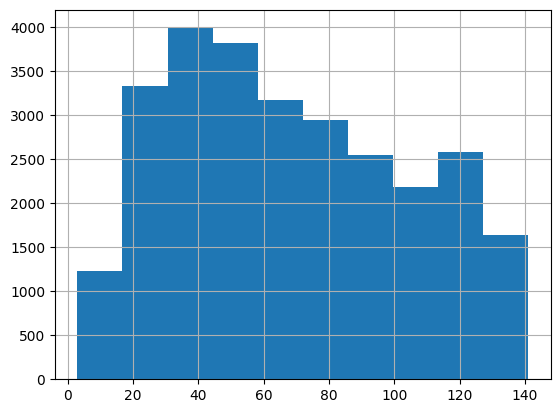

In [8]:
df['text'].str.len().hist(bins=10);

Найбільше постів довжиною до 70 символів – загалом, коротких і середніх постів більше, ніж довгих.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [9]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
english_stopwords = stopwords.words('english')

In [11]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language='english')

In [12]:
def tokenize(tokens):
  return [stemmer.stem(word) for word in word_tokenize(tokens)]

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
vectorizer = CountVectorizer(
    lowercase=True,
    tokenizer=tokenize,
    stop_words=english_stopwords+[',', '`', '?', '!', ':', ';', '.'],
    max_features=1000
)

In [15]:
vectorizer.fit(df['text'])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CountVectorizer(max_features=1000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x79e476e31260>)

In [16]:
inputs = vectorizer.transform(df['text'])

In [17]:
inputs.shape

(27480, 1000)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [18]:
from sklearn.preprocessing import LabelEncoder

df['sentiment_class'] = LabelEncoder().fit_transform(df['sentiment'])
df['sentiment_class'].value_counts()

,count
sentiment_class,
1,11117
2,8582
0,7781


In [19]:
from sklearn.model_selection import train_test_split

X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    inputs,
    df['sentiment_class'],
    test_size=0.3,
    random_state=42
)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

model_log = LogisticRegression(max_iter=1000, solver='sag')
model_tree = DecisionTreeClassifier(max_depth=20, random_state=42)
model_xgboost = XGBClassifier(max_depth=5, n_estimators=10)

In [21]:
model_log.fit(X_train_bow, y_train)

LogisticRegression(max_iter=1000, solver='sag')

In [22]:
model_tree.fit(X_train_bow, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [23]:
model_xgboost.fit(X_train_bow, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, ...)

In [24]:
train_log_preds = model_log.predict(X_train_bow)
test_log_preds = model_log.predict(X_test_bow)

train_tree_preds = model_tree.predict(X_train_bow)
test_tree_preds = model_tree.predict(X_test_bow)

train_xgboost_preds = model_xgboost.predict(X_train_bow)
test_xgboost_preds = model_xgboost.predict(X_test_bow)

In [25]:
from sklearn.metrics import accuracy_score, f1_score

print('train, log:', accuracy_score(train_log_preds, y_train.values), f1_score(train_log_preds, y_train.values, average='weighted'))
print('train, tree:', accuracy_score(train_tree_preds, y_train.values), f1_score(train_tree_preds, y_train.values, average='weighted'))
print('train, xgboost:', accuracy_score(train_xgboost_preds, y_train.values), f1_score(train_xgboost_preds, y_train.values, average='weighted'), '\n')

print('test, log:', accuracy_score(test_log_preds, y_test.values), f1_score(test_log_preds, y_test.values, average='weighted'))
print('test, tree:', accuracy_score(test_tree_preds, y_test.values), f1_score(test_tree_preds, y_test.values, average='weighted'))
print('test, xgboost:', accuracy_score(test_xgboost_preds, y_test.values), f1_score(test_xgboost_preds, y_test.values, average='weighted'))

train, log: 0.7410064462466209 0.7410579478048965
train, tree: 0.6614160948222083 0.6727461988770407
train, xgboost: 0.6357870659180703 0.648587273529803 

test, log: 0.6905628335759341 0.6911979365524368
test, tree: 0.6197234352256187 0.6346287017663751
test, xgboost: 0.6240902474526928 0.6394726689767435


Найкращою виявилась модель логістичної регресії з точністю 69% для тестових даних.

In [26]:
df['prediction'] = model_log.predict(inputs)

In [27]:
df.columns

Index(['textID', 'text', 'selected_text', 'sentiment', 'sentiment_class',
       'prediction'],
      dtype='object')

In [28]:
df[['sentiment_class', 'prediction']].value_counts(normalize=True)

sentiment_class  prediction
1                1             0.316849
2                2             0.230349
0                0             0.178675
                 1             0.088319
2                1             0.070852
1                0             0.043996
                 2             0.043705
0                2             0.016157
2                0             0.011099
Name: proportion, dtype: float64

In [29]:
df[['sentiment', 'sentiment_class']].value_counts()

,,count
sentiment,sentiment_class,
neutral,1,11117
positive,2,8582
negative,0,7781


In [30]:
df[df['sentiment_class'] != df['prediction']].head()

,textID,text,selected_text,sentiment,sentiment_class,prediction
2,088c60f138,my boss is bullying me...,bullying me,negative,0,1
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0,1
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0,1
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1,2
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,1,2


### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [31]:
feature_importance = pd.Series(
    model_log.coef_[0],
    index=vectorizer.get_feature_names_out(),
    name='imp'
).sort_values(ascending=False)

feature_importance[:10]

,imp
sad,2.500398
suck,2.330319
bore,2.201719
sorri,2.196756
hate,2.095782
fail,1.999708
worst,1.952491
disappoint,1.941485
weird,1.932223
poor,1.912112


In [32]:
feature_importance[-10:]

,imp
welcom,-1.667958
enjoy,-1.719471
amaz,-1.808822
congrat,-1.845505
smile,-1.852256
cute,-1.937250
love,-1.954428
thank,-1.975260
glad,-2.029900
awesom,-2.574082


На мою думку, більшість слів логічно є більш впливовими як негативно, так і позитивно.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
vectorizer_tf = TfidfVectorizer(
    lowercase=True,
    tokenizer=tokenize,
    stop_words=english_stopwords+[',', '`', '?', '!', ':', ';', '.'],
    max_features=1000
    )

In [37]:
vectorizer_tf.fit(df['text'])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=1000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x79e476e31260>)

In [39]:
inputs_tf = vectorizer_tf.transform(df['text'])

In [40]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(
    inputs_tf,
    df['sentiment_class'],
    test_size=0.3,
    random_state=42
)

In [43]:
model_tf = LogisticRegression(max_iter=1000).fit(X_train_tf, y_train_tf)
train_tf_preds = model_tf.predict(X_train_tf)
test_tf_preds = model_tf.predict(X_test_tf)

In [44]:
print('train, log:', accuracy_score(train_tf_preds, y_train_tf.values), f1_score(train_tf_preds, y_train_tf.values, average='weighted'))
print('test, log:', accuracy_score(test_tf_preds, y_test_tf.values), f1_score(test_tf_preds, y_test_tf.values, average='weighted'))

train, log: 0.7326887086712415 0.7326155725614498
test, log: 0.6888646288209607 0.6894332200540857


Якість класифікації кращою не стала, на жаль.

In [48]:
feature_importance = pd.Series(
    model_tf.coef_[0],
    index=vectorizer_tf.get_feature_names_out(),
    name='imp'
).sort_values(ascending=False)

feature_importance[:10]

,imp
sad,4.768681
miss,4.426249
suck,4.111963
sorri,4.014142
hate,3.841393
bore,3.591576
fail,3.289457
sick,3.250045
poor,3.084126
stupid,3.078776


In [49]:
feature_importance[-10:]

,imp
amaz,-2.196972
nice,-2.262868
cute,-2.331323
enjoy,-2.344405
glad,-2.513005
great,-2.550674
hope,-2.850013
awesom,-3.565470
thank,-3.788401
love,-4.191660


Більшість токенів, що найбільше впливають на модель, є схожою для обох моделей.

Зважаючи на трохи більше точність, я б обрала першу модель.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [50]:
df['prediction_tf'] = model_tf.predict(inputs_tf)

In [51]:
df[df['sentiment_class'] != df['prediction_tf']].head(15)

,textID,text,selected_text,sentiment,sentiment_class,prediction,prediction_tf
2,088c60f138,my boss is bullying me...,bullying me,negative,0,1,1
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0,1,1
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1,2,2
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,1,2,2
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,0,1,1
15,8a939bfb59,"Uh oh, I am sunburned","Uh oh, I am sunburned",negative,0,1,1
16,3440297f8b,"S`ok, trying to plot alternatives as we speak...",*sigh*,negative,0,1,1
17,919fa93391,i`ve been sick for the past few days and thus...,sick,negative,0,0,1
20,04d17ef61e,"oh Marly, I`m so sorry!! I hope you find her...","oh Marly, I`m so sorry!! I hope you find her ...",neutral,1,1,2
23,9ce5570064,gotta restart my computer .. I thought Win7 wa...,gotta restart my computer .. I thought Win7 wa...,neutral,1,0,0


Для того, щоб покращити якість класифікатора TF-IDF, можна:
- додатково проаналізувати і знайти патерни / слова, на яких модель неправильно визначає клас і додати їм більшої ваги
- попрацювати з посиланнями (форматувати або видалити їх, залишивши контекст розмови)
- тюнити гіперпараметри

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model